In [1]:
import enum
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath(".."))

from data_analysis.allowances_utils import get_allowances_data
from data_analysis.eurostat_crf_utils import *

## 1. Define the structure of facilities

In [2]:
# Year we want to visualize
YEAR = 2021
# Year we want to compare with (not necessarily the previous year)
YEAR_TO_COMPARE = 2020
SQUARE_VALUE_MT = 0.25


class SquareTypes(enum.Enum):
    ELECTRICITY_HEAT = 'EH'
    STEEL = 'S'
    RAFINERY = 'R'
    LIMEWORKS_CEMENTWORKS = 'LC'


definition = [
    {'facility_id': 1,
     'name': 'Elektrárna Počerady, a.s.',
     'permit_id': {'CZ-0204-05': SquareTypes.ELECTRICITY_HEAT,
                   'CZ-0478-12': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 2,
     'name': 'ArcelorMittal Ostrava a TAMEH Czech',
     'permit_id': {'CZ-0134-05': SquareTypes.STEEL,
                   'CZ-0444-10': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 3,
     'name': 'Třinecké železárny a Energetika Třinec',
     'permit_id': {'CZ-0192-05': SquareTypes.STEEL,
                   'CZ-0101-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 4,
     'name': 'Elektrárna Ledvice',
     'permit_id': {'CZ-0447-11': SquareTypes.ELECTRICITY_HEAT,
                   'CZ-0201-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 5,
     'name': 'Rafinerie Litvínov',
     'permit_id': {'CZ-0400-05': SquareTypes.RAFINERY,
                   'CZ-0160-05': SquareTypes.RAFINERY,
                   'CZ-0231-05': SquareTypes.RAFINERY},
     },
    {'facility_id': 6,
     'name': 'Elektrárna Prunéřov',
     'permit_id': {'CZ-0207-05': SquareTypes.ELECTRICITY_HEAT,
                   'CZ-0206-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 7,
     'name': 'Elektrárna Tušimice',
     'permit_id': {'CZ-0209-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 8,
     'name': 'Elektrárna Chvaletice',
     'permit_id': {'CZ-0200-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 9,
     'name': 'Elektrárna Mělník',
     'permit_id': {'CZ-0202-05': SquareTypes.ELECTRICITY_HEAT,
                   'CZ-0092-05': SquareTypes.ELECTRICITY_HEAT,
                   'CZ-0203-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 10,
     'name': 'Teplárna Vřesová',
     'permit_id': {'CZ-0197-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 11,
     'name': 'Teplárna Kladno',
     'permit_id': {'CZ-0148-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 12,
     'name': 'Elektrárna Opatovice',
     'permit_id': {'CZ-0080-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 13,
     'name': 'Elektrárna Dětmarovice',
     'permit_id': {'CZ-0198-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 14,
     'name': 'Teplárna Komořany',
     'permit_id': {'CZ-0190-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 15,
     'name': 'Elektrárna Třebovice',
     'permit_id': {'CZ-0317-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 16,
     'name': 'Českomoravský cement (Mokrá)',
     'permit_id': {'CZ-0260-15': SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {'facility_id': 17,
     'name': 'Elektrárna Tisová',
     'permit_id': {'CZ-0208-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 18,
     'name': 'Plzeňská teplárenská',
     'permit_id': {'CZ-0121-05': SquareTypes.ELECTRICITY_HEAT,
                   'CZ-0138-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 19,
     'name': 'Cement Hranice',
     'permit_id': {'CZ-0136-05': SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {'facility_id': 20,
     'name': 'CEMEX Czech Republic',
     'permit_id': {'CZ-0381-05': SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {'facility_id': 21,
     'name': 'Rafinerie Kralupy',
     'permit_id': {'CZ-0372-05': SquareTypes.RAFINERY},
     },
    {'facility_id': 22,
     'name': 'Elektrárna Trmice',
     'permit_id': {'CZ-0237-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 23,
     'name': 'Lafarge Cement',
     'permit_id': {'CZ-0193-05': SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {'facility_id': 24,
     'name': 'Českomoravský cement (Radotín)',
     'permit_id': {'CZ-0261-15': SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {'facility_id': 25,
     'name': 'Elektrárna Kralupy',
     'permit_id': {'CZ-0259-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 26,
     'name': 'Vápenka Čertovy schody',
     'permit_id': {'CZ-0144-05': SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
    {'facility_id': 27,
     'name': 'Teplárna Mladá Boleslav',
     'permit_id': {'CZ-0256-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 28,
     'name': 'Mondi Štětí',
     'permit_id': {'CZ-0147-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 29,
     'name': 'Elektrárna Poříčí',
     'permit_id': {'CZ-0205-05': SquareTypes.ELECTRICITY_HEAT},
     },
    {'facility_id': 30,
     'name': 'Vápenka Vitošov',
     'permit_id': {'CZ-0178-05': SquareTypes.LIMEWORKS_CEMENTWORKS},
     },
]

## 2. Load data (with minor adjustments)

In [3]:
def fix_allowance_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns={"value": "MtCO2eq"})
    df = df.drop("MAIN_ACTIVITY_TYPE_CODE", axis=1)
    return df

In [4]:
allowances_df = fix_allowance_df(get_allowances_data(
    YEAR, "CZ", None, "../data/EUA/verified_emissions_2021_en.xlsx"))
allowances_df.head(1)

,MtCO2eq,IDENTIFIER_IN_REG
PERMIT_IDENTIFIER,,
CZ-0204-05,4.419807,"Elektrárna Počerady, a.s."


## 3. Add facility details to the data frame

In [5]:
def _map_permit_id_to_facility_id(permit_id: str) -> int:
    for facility in definition:
        if permit_id in facility['permit_id']:
            return facility['facility_id']


def _map_permit_id_to_square_type(permit_id: int) -> str:
    for facility in definition:
        if permit_id in facility['permit_id']:
            return facility['permit_id'][permit_id].value


def _map_facility_id_to_facility_name(facility_id: int) -> str:
    for facility in definition:
        if facility_id == facility['facility_id']:
            return facility['name']


def add_facility_details(df: pd.DataFrame) -> None:
    """Map permit to facility id, facility name and to square type """
    # Find and add square_type to an allowance
    df['square_type'] = df.index.to_series().apply(_map_permit_id_to_square_type)
    # Find and add facility_id to an allowance
    df["facility_id"] = df.index.to_series().apply(_map_permit_id_to_facility_id)
    # Find and add facility_name to an allowance
    df['facility_name'] = df['facility_id'].apply(_map_facility_id_to_facility_name)

In [6]:
top_30 = allowances_df.copy()
# Add facility id, name and square types.
add_facility_details(top_30)
# Select only the top30 facilities (i.e. those that have a facility_id defined).
top_30 = top_30[top_30.facility_id.notna()]
# Remove decimals from facility_id
top_30["facility_id"] = top_30["facility_id"].astype(int)
top_30.head(2)

,MtCO2eq,IDENTIFIER_IN_REG,square_type,facility_id,facility_name
PERMIT_IDENTIFIER,,,,,
CZ-0204-05,4.419807,"Elektrárna Počerady, a.s.",EH,1,"Elektrárna Počerady, a.s."
CZ-0201-05,3.781199,ČEZ - Elektrárna Ledvice,EH,4,Elektrárna Ledvice


## 4. Create emissions pivot table with columns per square type

In [7]:
def create_pivot_df_grouped_by_facility_id(df: pd.DataFrame) -> pd.DataFrame:
    """
    Group by `facility_id` and `square_type` and sum `MtCO2eq` emissions by type, then pivot by
    `facility_id`, turning individual square types to columns.
    """
    df = df.groupby(["facility_id", 'square_type']).sum().round(2)
    df = pd.pivot_table(
        df, index=['facility_id'], columns='square_type', values="MtCO2eq", fill_value=0)
    df.astype(int)
    return df

In [8]:
pivot_df = create_pivot_df_grouped_by_facility_id(top_30)
pivot_df.head(3)

square_type,EH,LC,R,S
facility_id,,,,
1,5.39,0.0,0.0,0.00
2,2.04,0.0,0.0,3.08
3,1.51,0.0,0.0,2.53


## 5. Add back facility name and total emissions, add square counts

In [9]:
def create_df_facility_emision_value(df):
    """Group by facility_id and name_id, sum  MtCO2eq emisions by facility"""
    df = df.drop(["IDENTIFIER_IN_REG", "square_type"], axis=1)
    return df.groupby(["facility_id", 'facility_name']).sum().round(2)


def add_squares_count(df) -> None:
    """Computes and adds squares for the total emissions and per emissions type as new columns"""
    df['sq_TOTAL'] = (df['MtCO2eq'] / SQUARE_VALUE_MT).round().astype(int)
    for square_type in SquareTypes:
        df[f'sq_{square_type.value}'] = (df[(square_type.value)] / SQUARE_VALUE_MT).round().astype(int)

In [10]:
# Group by facility_id, sum emmisions, compute total squares.
facility_emission_value_df = create_df_facility_emision_value(top_30)
df_output = facility_emission_value_df.join(pivot_df)
# Add squares count (total and per each type).
add_squares_count(df_output)
# Make a copy of df and replace zeros in the copy for better legibility
df_output_to_view = df_output.copy()
df_output_to_view.replace(0,'-',inplace=True)
df_output_to_view

,,MtCO2eq,EH,LC,R,S,sq_TOTAL,sq_EH,sq_S,sq_R,sq_LC
facility_id,facility_name,,,,,,,,,,
1,"Elektrárna Počerady, a.s.",5.39,5.39,-,-,-,22,22,-,-,-
2,ArcelorMittal Ostrava a TAMEH Czech,5.12,2.04,-,-,3.08,20,8,12,-,-
3,Třinecké železárny a Energetika Třinec,4.04,1.51,-,-,2.53,16,6,10,-,-
4,Elektrárna Ledvice,3.78,3.78,-,-,-,15,15,-,-,-
5,Rafinerie Litvínov,3.71,-,-,3.71,-,15,-,-,15,-
6,Elektrárna Prunéřov,3.49,3.49,-,-,-,14,14,-,-,-
7,Elektrárna Tušimice,3.40,3.4,-,-,-,14,14,-,-,-
8,Elektrárna Chvaletice,3.40,3.4,-,-,-,14,14,-,-,-
9,Elektrárna Mělník,2.39,2.39,-,-,-,10,10,-,-,-


## 6. Create a df for the previous year situation to find out the changes  

In [11]:
# Repeat the same for the comparison data frame.

# 1. Get the data
compare_allowances_df = fix_allowance_df(get_allowances_data(
    YEAR_TO_COMPARE, "CZ", None, "../data/EUA/verified_emissions_2021_en.xlsx"))
# 2. Add facility details
add_facility_details(compare_allowances_df)
# 3. Create emissions pivot table
compare_pivot_df = create_pivot_df_grouped_by_facility_id(compare_allowances_df)
# 4. Add back facility name and total emissions, add square counts
compare_facility_emission_value_df = create_df_facility_emision_value(compare_allowances_df)
compare_df_output = compare_facility_emission_value_df.join(compare_pivot_df)
add_squares_count(compare_df_output)

compare_df_output.head(3)

,,MtCO2eq,EH,LC,R,S,sq_TOTAL,sq_EH,sq_S,sq_R,sq_LC
facility_id,facility_name,,,,,,,,,,
1.0,"Elektrárna Počerady, a.s.",5.81,5.81,0.0,0.0,0.00,23,23,0,0,0
2.0,ArcelorMittal Ostrava a TAMEH Czech,3.99,1.65,0.0,0.0,2.34,16,7,9,0,0
3.0,Třinecké železárny a Energetika Třinec,4.39,1.55,0.0,0.0,2.84,18,6,11,0,0


## 7. Compute table to see the changes in comparison with the chosen year 

In [12]:
diff_df = df_output.subtract(compare_df_output)

# Filter out items with no difference
zero_condition = diff_df["sq_TOTAL"] == 0.0
for square_type in SquareTypes:
  zero_condition &= diff_df[f"sq_{square_type.value}"] == 0.0

# Make a copy of df and replace zeros in the copy for better legibility
diff_df_to_view = diff_df[~zero_condition].copy()
diff_df_to_view.replace(0,'-',inplace=True)
diff_df_to_view

,,MtCO2eq,EH,LC,R,S,sq_TOTAL,sq_EH,sq_S,sq_R,sq_LC
facility_id,facility_name,,,,,,,,,,
1,"Elektrárna Počerady, a.s.",-0.42,-0.42,-,-,-,-1,-1,-,-,-
2,ArcelorMittal Ostrava a TAMEH Czech,1.13,0.39,-,-,0.74,4,1,3,-,-
3,Třinecké železárny a Energetika Třinec,-0.35,-0.04,-,-,-0.31,-2,-,-1,-,-
4,Elektrárna Ledvice,1.04,1.04,-,-,-,4,4,-,-,-
5,Rafinerie Litvínov,0.51,-,-,0.51,-,2,-,-,2,-
7,Elektrárna Tušimice,-0.33,-0.33,-,-,-,-1,-1,-,-,-
8,Elektrárna Chvaletice,1.16,1.16,-,-,-,5,5,-,-,-
9,Elektrárna Mělník,-0.54,-0.54,-,-,-,-2,-2,-,-,-
10,Teplárna Vřesová,-1.02,-1.02,-,-,-,-4,-4,-,-,-


## 8. Check top 10 allowances which did not make it to the "top 30" facilities. 

In [13]:
# Join all permit ids from the top-30 definition into one list.
permit_ids = []
for facility in definition:
  permit_ids += list(facility['permit_id'].keys())

# Drop allowances in top 30.
below_thirty_df = allowances_df[~allowances_df.index.isin(permit_ids)].copy()

# Group , compute squares, remove decimals from "squares"
below_thirty_df['squares'] = (below_thirty_df['MtCO2eq'] / SQUARE_VALUE_MT).round().astype(int)

below_thirty_df.head(10)

,MtCO2eq,IDENTIFIER_IN_REG,squares
PERMIT_IDENTIFIER,,,
CZ-0284-05,0.298959,Teplárna České Budějovice,1
CZ-0235-05,0.287896,DEZA - teplárna závodu,1
CZ-0321-05,0.286761,Veolia Energie - Teplárna Olomouc,1
CZ-0085-05,0.280815,Teplárna Otrokovice - Teplárna,1
CZ-0328-05,0.256224,Veolia Energie - Teplárna Karviná,1
CZ-0091-05,0.237652,Teplárna Zlín s.r.o.,1
CZ-0181-05,0.237495,Lovochemie - Uhelná kotelna,1
CZ-0048-05,0.224220,Synthesia - odštěpný závod SYNTHESIA,1
CZ-0334-05,0.175298,AGC Flat Glass - závod Řetenice,1


## 9. Charts and texts 

In [14]:
def percentage(part, whole):
    return (part / whole) * 100

In [15]:
def draw_barh_charts (df):
    color = ['dimgrey','silver']
    df_charts.plot.barh(stacked=True, color = color, legend = False)
    # Upper chart
    plt.text(part_2-62, 0.91, f'{part_1:.0f} %', size = 30, color = 'silver')
    plt.text(0,1.3, f'Podíl emisních povolenek na celkových ročních emisí ČR v roce {YEAR}.', size = 15)

    # lower chart
    plt.text(part_1-33, -0.075,f'{part_2:.0f} %', size = 30, color = 'silver');
    plt.text(0,0.3, f'Emitenti zobrazení v mapě odpovídají za {part_2:.0f} % emisí z těchto povolenek.', size = 15)

    # Both charts
    plt.axis('off');

In [16]:
# Fetch total emissions data
df_emis = get_eurostat_crf_data_for_code("TOTX4_MEMONIA", YEAR)

In [17]:
# Variables
cr_total = df_emis.loc['CZ','value'] # Total CR emissions for chosen year, MtCO2eq.
cr_allow = allowances_df['MtCO2eq'].sum() # Total emissions covered by allowances for chosen year, MtCO2eq.
cr_emit_in_map = df_output['MtCO2eq'].sum() # Total emissions displayed in map for chosen year, MtCO2eq.

In [18]:
# Compute percentage
part_1 = (percentage(cr_allow,cr_total)) # Allowances in % relative to CR.
part_2 = (percentage(cr_emit_in_map,cr_allow)) # Emitters in map in % relative to allowances emissions.
part_3 = (percentage(cr_emit_in_map,cr_total)) # Emitters in map in % relative to CR.

In [19]:
# Create df as a source for the charts.
data_charts = {'allowances':[part_2-part_1, part_1], 'other':[part_1-(part_2-part_1),100-part_1]}
df_charts = pd.DataFrame(data_charts, index=['CR_2','CR_rel'])

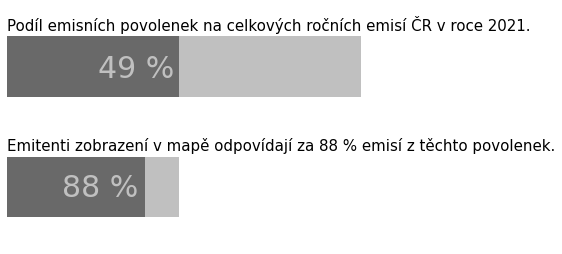

In [20]:
# Draw charts
draw_barh_charts(df_charts)

In [21]:
# Print chart description
print(f'''
Horní graf:
- Celkové množství emisí ČR v roce {YEAR} činí {cr_total:.1f}  Mt CO2eq.
- Emisní povolenky pokrývají {part_1:.0f} % celkových ročních emisí ČR za rok {YEAR}.'
''')

print(f'''
Dolní graf:
- Emitenti zobrazení v mapě odpovídají za {part_2:.0f} % emisí z těchto povolenek. To odpovídá {part_3:.0f} % všech emisí v ČR.
''')


Horní graf:
- Celkové množství emisí ČR v roce 2021 činí 119.4  Mt CO2eq.
- Emisní povolenky pokrývají 49 % celkových ročních emisí ČR za rok 2021.'


Dolní graf:
- Emitenti zobrazení v mapě odpovídají za 88 % emisí z těchto povolenek. To odpovídá 43 % všech emisí v ČR.



In [22]:
# Print backing texts
print(f'''
Mapa zobrazuje 30 největších zdrojů emisí skleníkových plynů v České republice – elektrárny a teplárny, ocelárny, cementárny a rafinerie. Zobrazení emitenti představují {part_2:.0f} % emisí pokrytých emisními povolenkami ze systému EU ETS pro Českou republiku a celkově {part_3:.0f} % ročních emisí skleníkových plynů České republiky.
''')

print(f'''
U každého zdroje je znázorněno množství emisí, jeden čtvereček odpovídá 250 000 t CO2eq. Barvy odlišují jednotlivá zařízení podle typu hlavní aktivity: elektrárny a teplárny, vápenky a cementárny, rafinérie, železárny a ocelárny. V oblasti Západních Čech je nakumulována většina zařízení určených k výrobě elektřiny a tepla, zatímco v Moravskoslezském kraji jsou hlavními emitenty podniky určené k výrobě železa a oceli. Významným zdrojem emisí CO2 jsou také cementárny, jejichž celkový příspěvek v roce {YEAR} činil {df_output['LC'].sum().round(1)} Mt CO2eq.
''')

print(f'''
Pro přehlednost jsme u některých zdrojů sloučili více různých emitentů registrovaných v systému ETS do jednoho zobrazeného celku. Např. Plzeňská teplárenská má zvlášť registrované dvě velké teplárny v různých částech města nebo mnohé elektrárny mají zvlášť registrované svoje jednotlivé bloky. Dále jsme přiřadili k hutním podnikům jejich teplárenské složky, protože jsou nutnou součástí jejich provozu (to je jisté zjednodušení, protože tyto teplárenské podniky část vyrobeného tepla či páry dodávají i externím zákazníkům).
''')

print(f'''
Prakticky všechny zobrazené zdroje emisí produkují pouze CO2, jen rafinerie mohou vedle CO2 vytvářet další skleníkové plyny. V rámci systému obchodování s emisními povolenkami EU ETS i v naší grafice jsou jiné skleníkové plyny než oxid uhličitý převedeny na ekvivalentní množství CO2, označované CO2eq.
''')

print(f'''
Nejvíce ze zobrazených zařízení vlastní ČEZ, další jsou ve vlastnictví Sev.en Energy, Skupiny TAURON a LIBERTY Steel Group.
''')

print(f'''
Další poznámky:
''')


print(f'''
Evropský ETS byl spuštěn v roce 2005 jako první mezinárodní systém pro obchodování s emisními povolenkami a pokrývá přibližně 40 % emisí skleníkových plynů v EU, především v sektorech energetiky, těžkého průmyslu a letectví. Data z EU ETS poskytují souhrnné údaje o emisích a povolenkách podle zemí, odvětví a roku a pocházejí hlavně z protokolu transakcí EU EUTL. Data jsou poskytována Evropskou komisí a spravována Evropskou agenturou pro životní prostředí.
''')

print(f'''
Pro širší kontext si můžete prohlédnout uhelné elektrárny světa na interaktivní mapě, která mj. umožňuje i posun v čase. Odpoví na otázky typu kdy nastal uhelný boom v Číně nebo jak výkonné máme elektrárny třeba oproti Polsku.
''')


Mapa zobrazuje 30 největších zdrojů emisí skleníkových plynů v České republice – elektrárny a teplárny, ocelárny, cementárny a rafinerie. Zobrazení emitenti představují 88 % emisí pokrytých emisními povolenkami ze systému EU ETS pro Českou republiku a celkově 43 % ročních emisí skleníkových plynů České republiky.


U každého zdroje je znázorněno množství emisí, jeden čtvereček odpovídá 250 000 t CO2eq. Barvy odlišují jednotlivá zařízení podle typu hlavní aktivity: elektrárny a teplárny, vápenky a cementárny, rafinérie, železárny a ocelárny. V oblasti Západních Čech je nakumulována většina zařízení určených k výrobě elektřiny a tepla, zatímco v Moravskoslezském kraji jsou hlavními emitenty podniky určené k výrobě železa a oceli. Významným zdrojem emisí CO2 jsou také cementárny, jejichž celkový příspěvek v roce 2021 činil 3.5 Mt CO2eq.


Pro přehlednost jsme u některých zdrojů sloučili více různých emitentů registrovaných v systému ETS do jednoho zobrazeného celku. Např. Plzeňská teplár